In [1]:
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
# from torchvision.models import inception_v3
# import numpy as np
# from scipy.linalg import sqrtm

# 读取并处理数据集：

In [2]:
data_dir = '../dataset/face_imgs'

transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

batch_size = 4
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4)


def denorm(x):
    out = (x * 0.5) + 0.5
    return out.clamp(0, 1)

# 展示部分数据集：

In [3]:
img, label = dataset[0]
print('Label: ', label)
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label:  0
tensor([[[-0.8588, -0.8588, -0.8588, -0.8667, -0.8667],
         [-0.8588, -0.8588, -0.8588, -0.8588, -0.8667],
         [-0.8510, -0.8588, -0.8588, -0.8588, -0.8588],
         [-0.8510, -0.8510, -0.8588, -0.8588, -0.8667],
         [-0.8510, -0.8588, -0.8588, -0.8588, -0.8588]],

        [[-0.8588, -0.8431, -0.8431, -0.8510, -0.8510],
         [-0.8588, -0.8431, -0.8510, -0.8510, -0.8510],
         [-0.8510, -0.8510, -0.8588, -0.8588, -0.8588],
         [-0.8510, -0.8510, -0.8588, -0.8588, -0.8667],
         [-0.8510, -0.8588, -0.8588, -0.8588, -0.8588]],

        [[-0.8588, -0.8510, -0.8510, -0.8588, -0.8588],
         [-0.8588, -0.8510, -0.8510, -0.8510, -0.8588],
         [-0.8510, -0.8588, -0.8588, -0.8588, -0.8588],
         [-0.8510, -0.8510, -0.8588, -0.8588, -0.8667],
         [-0.8510, -0.8588, -0.8588, -0.8588, -0.8588]]])


(tensor(-0.9843), tensor(0.5765))

Label:  0


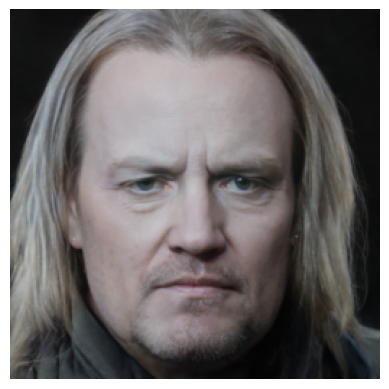

In [4]:
%matplotlib inline

img_norm = denorm(img)
img_show = img_norm.permute(1, 2, 0).numpy()
print('Label: ', label)
plt.imshow(img_show)
plt.axis('off')
plt.show()

first batch
torch.Size([4, 3, 256, 256])
[[[0.48235294 0.4509804  0.39215687]
  [0.4862745  0.44313726 0.38039216]
  [0.48235294 0.4392157  0.38039216]
  ...
  [0.4392157  0.4        0.3529412 ]
  [0.4392157  0.40392157 0.35686275]
  [0.44705883 0.41568628 0.3647059 ]]

 [[0.47843137 0.44313726 0.38431373]
  [0.4862745  0.44705883 0.3882353 ]
  [0.48235294 0.44705883 0.3882353 ]
  ...
  [0.44313726 0.40392157 0.35686275]
  [0.44313726 0.40784314 0.36078432]
  [0.44705883 0.41568628 0.36078432]]

 [[0.47843137 0.44313726 0.3764706 ]
  [0.4745098  0.44705883 0.3882353 ]
  [0.47843137 0.45490196 0.39215687]
  ...
  [0.44705883 0.40784314 0.36078432]
  [0.44705883 0.41568628 0.36078432]
  [0.44705883 0.41568628 0.35686275]]

 ...

 [[0.11372548 0.10196078 0.08235294]
  [0.10588235 0.09411764 0.08235294]
  [0.10196078 0.0862745  0.07843137]
  ...
  [0.14117646 0.12156862 0.10980392]
  [0.12941176 0.11372548 0.10196078]
  [0.1372549  0.12156862 0.10980392]]

 [[0.12156862 0.10980392 0.090196

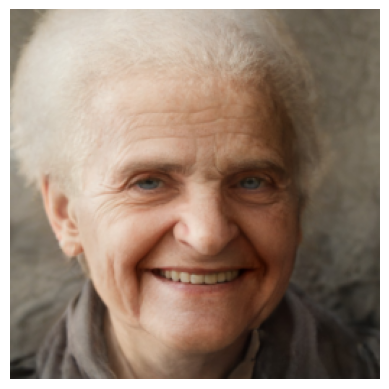

In [5]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    img_norm = denorm(img_batch[0])
    img_show = img_norm.permute(1, 2, 0).numpy()
    print(img_show)
    plt.imshow(img_show)
    plt.axis('off')
    plt.show()
    break

# 使用GPU加速：

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 构建网络框架：

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        
        out = self.prelu(x + residual)
        return out


class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 768, 4, 1, 0, bias=False),
            nn.BatchNorm2d(768),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(768, 384, 4, 2, 1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(384, 192, 4, 2, 1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(192, 96, 4, 2, 1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            ResidualBlock(96),

            nn.ConvTranspose2d(96, 48, 4, 2, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(48, 24, 4, 2, 1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(24, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z.view(-1, latent_size, 1, 1))

In [8]:
latent_size = 150

G = Generator(latent_size)
D = Discriminator()

# 测试生成网络：

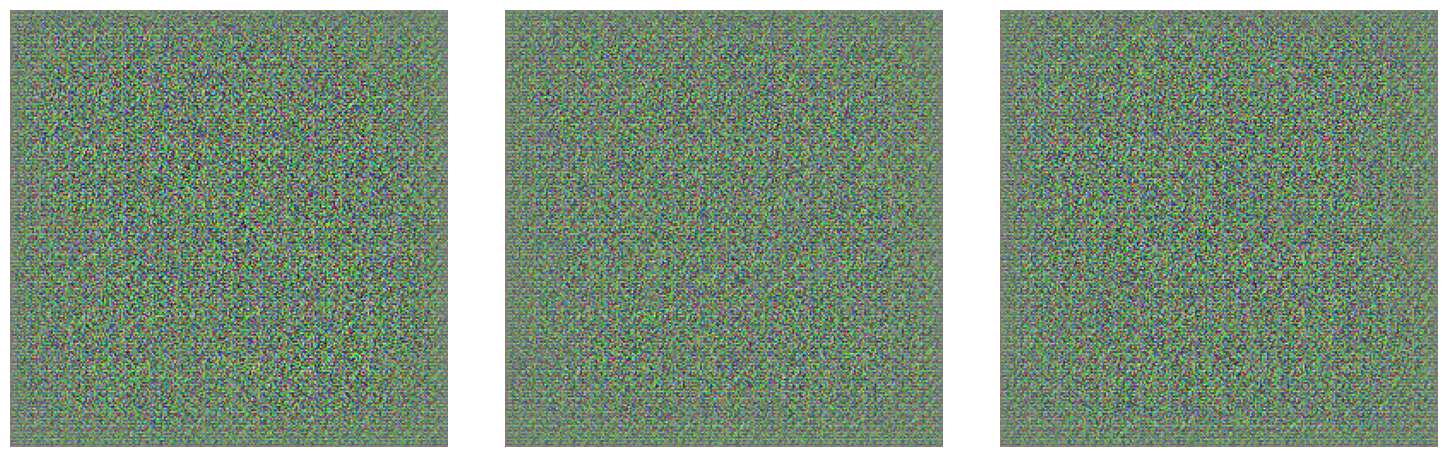

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)

sample_vectors = torch.randn(3, latent_size, 1, 1).to(device)

with torch.no_grad():
    y = G(sample_vectors)
    gen_imgs = denorm(y).cpu()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 9))
fig.tight_layout()

for i in range(3):
    img = gen_imgs[i].permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

# 部署生成器和辨别器

In [10]:
G.to(device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(150, 768, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(768, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ResidualBlock(
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1):

In [11]:
D.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1,

# 设置学习率和选择器：

In [12]:
criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0005, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999))

d_scheduler = StepLR(d_optimizer, step_size=250, gamma=0.9)
g_scheduler = StepLR(g_optimizer, step_size=250, gamma=0.9)

# 定义训练方法：

In [13]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = 0.9 * torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    real_labels = real_labels.squeeze()
    fake_labels = fake_labels.squeeze()

    # Loss for real images
    real_outputs = D(images).squeeze()
    d_loss_real = criterion(real_outputs, real_labels)
    real_score = real_outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_outputs = D(fake_images).squeeze()
    d_loss_fake = criterion(fake_outputs, fake_labels)
    fake_score = fake_outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score


def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z.squeeze())

    real_labels = torch.ones(batch_size, 1).to(device)

    g_loss = criterion(D(fake_images), real_labels.squeeze())

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# 保存训练样本：

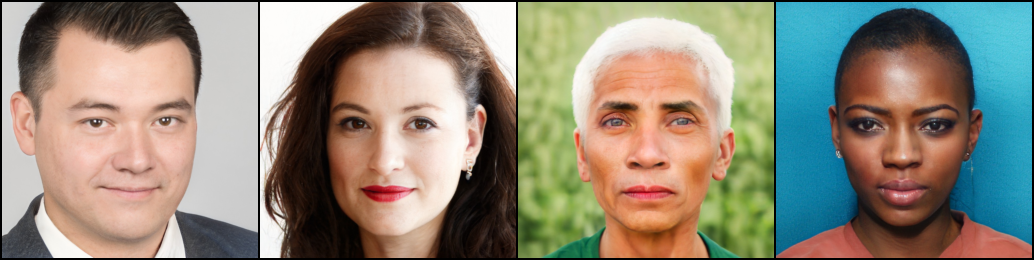

In [14]:
sample_dir = '../DCGAN_14/sample'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 3, 256, 256)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=4)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


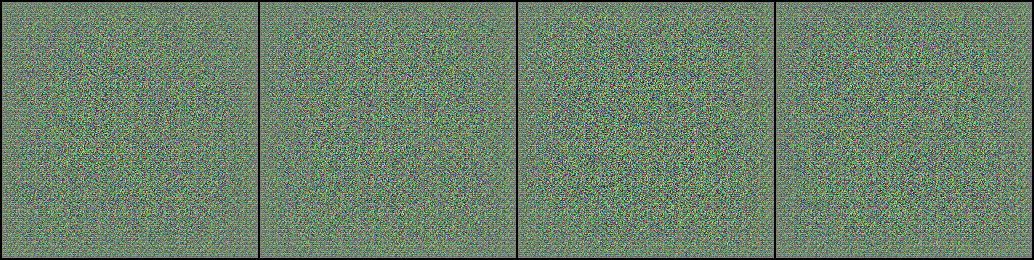

In [15]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)


def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 256, 256)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=4)


# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

# 定义存档点：

In [16]:
def save_checkpoint(epoch, generator, discriminator, g_optimizer, d_optimizer, filepath):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict()
    }, filepath)

# 定义计算FID函数

In [17]:
# def calculate_fid(real_images, fake_images, inception_model):
#     # 确保Inception模型为评估模式
#     inception_model.eval()
# 
#     # 获取真实图像和生成图像的特征
#     real_features = inception_model(real_images).detach().cpu().numpy()
#     fake_features = inception_model(fake_images).detach().cpu().numpy()
# 
#     # 计算特征的均值和协方差
#     mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
#     mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
# 
#     # 计算FID得分
#     ssdiff = np.sum((mu1 - mu2) ** 2.0)
#     covmean = sqrtm(sigma1.dot(sigma2))
# 
#     # 防止复数
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real
# 
#     fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#     return fid

# 加载预训练的Inception模型

In [18]:
# inception_model = inception_v3(pretrained=True, transform_input=False)
# inception_model.fc = torch.nn.Identity()  # 移除最后的全连接层
# inception_model = inception_model.to(device)

# 训练模型：

In [19]:
num_epochs = 800
g_update_frequency = 1
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
d_losses_avg, g_losses_avg, real_scores_avg, fake_scores_avg = [], [], [], []
real_score, fake_score, d_loss, g_loss = 0, 0, 0, 0
checkpoint_dir = './checkpoints'

for epoch in range(num_epochs):
    d_loss_accum = 0.0
    g_loss_accum = 0.0
    real_score_accum = 0.0
    fake_score_accum = 0.0
    steps_per_epoch = 0

    for i, (images, _) in enumerate(data_loader):
        steps_per_epoch += 1
        images = images.to(device)

        # 训练判别器
        noise = torch.randn_like(images) * 0.1
        noisy_images = images + noise
        d_loss, real_score, fake_score = train_discriminator(noisy_images)

        # 多次更新生成器
        for _ in range(g_update_frequency):
            g_loss, fake_images = train_generator()

        # 累加损失和分数
        d_loss_accum += d_loss.item()
        g_loss_accum += g_loss.item()
        real_score_accum += real_score.mean().item()
        fake_score_accum += fake_score.mean().item()

        # 记录损失和分数
        if (i + 1) % 125 == 0:
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # 计算并存储每个epoch的平均损失和分数
    d_losses_avg.append(d_loss_accum / steps_per_epoch)
    g_losses_avg.append(g_loss_accum / steps_per_epoch)
    real_scores_avg.append(real_score_accum / steps_per_epoch)
    fake_scores_avg.append(fake_score_accum / steps_per_epoch)

    # 打印每个epoch的平均损失和分数
    print(
        f'Epoch [{epoch}/{num_epochs}], Average D_loss: {d_losses_avg[-1]:.4f}, Average G_loss: {g_losses_avg[-1]:.4f}, Average Real Score: {real_scores_avg[-1]:.4f}, Average Fake Score: {fake_scores_avg[-1]:.4f}')

    # 更新调度器
    d_scheduler.step()
    g_scheduler.step()

    # 每100个epochs保存一次检查点
    if (epoch + 1) % 100 == 0:
        checkpoint_path = f'{checkpoint_dir}/checkpoint_epoch_{epoch + 1}.pth'
        save_checkpoint(epoch + 1, G, D, g_optimizer, d_optimizer, checkpoint_path)

    # # 在每个epoch结束时计算FID得分
    # with torch.no_grad():
    #     real_images = next(iter(data_loader))[0].to(device)
    #     z = torch.randn(batch_size, latent_size, 1, 1).to(device)
    #     fake_images = G(z)
    #     fid_score = calculate_fid(real_images, fake_images, inception_model)
    #     print(f'Epoch [{epoch}/{num_epochs}], FID Score: {fid_score}')

    # 保存生成的图片
    save_fake_images(epoch + 1)

Epoch [0/800], Step [125/625], d_loss: 0.9575, g_loss: 1.3001, D(x): 0.94, D(G(z)): 0.42
Epoch [0/800], Step [250/625], d_loss: 0.8864, g_loss: 1.6808, D(x): 0.50, D(G(z)): 0.16
Epoch [0/800], Step [375/625], d_loss: 1.3691, g_loss: 4.9797, D(x): 0.80, D(G(z)): 0.51
Epoch [0/800], Step [500/625], d_loss: 1.3407, g_loss: 1.5219, D(x): 0.37, D(G(z)): 0.24
Epoch [0/800], Step [625/625], d_loss: 1.6692, g_loss: 1.6123, D(x): 0.53, D(G(z)): 0.53
Epoch [0/800], Average D_loss: 1.3546, Average G_loss: 2.0144, Average Real Score: 0.5749, Average Fake Score: 0.3251
Saving fake_images-0001.png
Epoch [1/800], Step [125/625], d_loss: 1.1530, g_loss: 0.8014, D(x): 0.49, D(G(z)): 0.24
Epoch [1/800], Step [250/625], d_loss: 1.5020, g_loss: 2.5101, D(x): 0.70, D(G(z)): 0.48
Epoch [1/800], Step [375/625], d_loss: 1.9250, g_loss: 2.1338, D(x): 0.35, D(G(z)): 0.27
Epoch [1/800], Step [500/625], d_loss: 1.6080, g_loss: 0.4153, D(x): 0.75, D(G(z)): 0.68
Epoch [1/800], Step [625/625], d_loss: 1.2797, g_loss

KeyboardInterrupt: 

# 保存模型：

In [ ]:
torch.save(G.state_dict(), './checkpoints/G.ckpt')
torch.save(D.state_dict(), './checkpoints/D.ckpt')

# 展示部分训练结果：

In [ ]:
Image('./sample/fake_images-0010.png')

In [ ]:
Image('./sample/fake_images-0050.png')

In [ ]:
Image('./sample/fake_images-0100.png')

In [ ]:
Image('./sample/fake_images-0150.png')

In [ ]:
Image('./sample/fake_images-0200.png')

In [ ]:
Image('./sample/fake_images-0250.png')

In [ ]:
Image('./sample/fake_images-0300.png')

In [ ]:
Image('./sample/fake_images-0350.png')

In [ ]:
Image('./sample/fake_images-0400.png')

In [ ]:
Image('./sample/fake_images-0450.png')

In [ ]:
Image('./sample/fake_images-0500.png')

In [ ]:
Image('./sample/fake_images-0550.png')

In [ ]:
Image('./sample/fake_images-0600.png')

In [ ]:
Image('./sample/fake_images-0650.png')

In [ ]:
Image('./sample/fake_images-0700.png')

In [ ]:
Image('./sample/fake_images-0750.png')

In [ ]:
Image('./sample/fake_images-0800.png')

# 保存训练视频：

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'imgs_generation.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 8, (1034, 260))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('imgs_generation.avi')

# 训练过程可视化：

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
plt.plot(d_losses_avg, '-')
plt.plot(g_losses_avg, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Average Losses')

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')

In [ ]:
plt.plot(real_scores_avg, '-')
plt.plot(fake_scores_avg, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Average Scores')

# 使用模型生成图像：

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)

G.load_state_dict(torch.load('./checkpoints/G.ckpt'))

latent_size = G.model[0].in_channels
sample_vectors = torch.randn(5, latent_size, 1, 1).to(device)

with torch.no_grad():
    y = G(sample_vectors)
    gen_imgs = denorm(y).cpu()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
fig.tight_layout()

for i in range(5):
    img = gen_imgs[i].permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()